In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import sf_utils

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statannotations.Annotator import Annotator


import seaborn as sns

sc.settings.set_figure_params(dpi=80, facecolor='white', fontsize=14, scanpy=True, format='pdf')
sc.set_figure_params(figsize=(5,5))

sc.settings.verbosity=3

# Plot clonal expansion on UMAP

In [3]:
#load cce for whole clones (available on figshare)
adata_mult_coembed = sc.read_h5ad("../proc_files/lsk_full_coembed_whole_clones.h5ad")

In [4]:
umap_df = pd.DataFrame(np.hstack((adata_mult_coembed.obsm['X_draw_graph_fa'],(adata_mult_coembed.obs[['clone.size (RNA)','clone.size (ATAC)',
                                                                                                      'clone.size (RNA & ATAC)','fate_pct']].values))),
                       index=adata_mult_coembed.obs_names, columns=['x','y','size_rna','size_atac','size_net','fate_pct'])

In [5]:
umap_df = umap_df[(umap_df.size_rna > 0) & (umap_df.size_atac > 0)].copy()

In [6]:
# umap_df.size_atac = umap_df.size_atac.rank()
# umap_df.size_rna = umap_df.size_rna.rank()

In [7]:
umap_df = umap_df.sample(1000).copy()

No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


Text(0.5, 1.0, 'ATAC clone size')

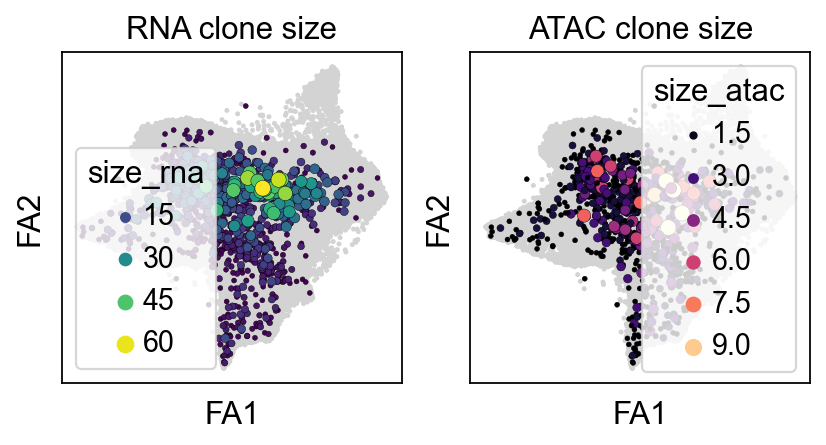

In [8]:
fig=plt.figure(figsize=(6,6))
gs=GridSpec(2,2)

ax = plt.subplot(gs[0])
sc.pl.draw_graph(adata_mult_coembed[adata_mult_coembed.obs.node_type=='cell'], s=20, ax=ax, show=False)
sns.scatterplot(x = 'x', y='y', data=umap_df.sort_values('size_net'),
               hue = 'size_rna', palette='viridis', edgecolor='black', linewidth=0.2,
                size=(umap_df.sort_values('size_net')['size_rna']), sizes=(5,50))
plt.title('RNA clone size')


ax = plt.subplot(gs[1])
sc.pl.draw_graph(adata_mult_coembed[adata_mult_coembed.obs.node_type=='cell'], s=20, ax=ax, show=False)
sns.scatterplot(x = 'x', y='y', data=umap_df.sort_values('size_net'),
               hue = 'size_atac', palette='magma', edgecolor='black', linewidth=0.2,
                size=(umap_df.sort_values('size_net')['size_atac']), sizes=(5,50))
plt.title('ATAC clone size')

# plt.savefig("plots/cc_emb_clonal_expansion.pdf")

# Fate composition plot

In [9]:
clone_table = pd.read_csv("../../hsc.rna&atac.r1&2_master_v2.csv").drop_duplicates('clone.id')

In [10]:
clone_table.fate.value_counts()

Mono             3006
MPP               689
Ery/Meg           401
Neutro            400
MEP               395
uns               367
MPP/GMP           355
Unk_3             322
no_fate_cells     305
Unk_1             201
Unk_2             111
Lym               102
Baso/Eos/Mast      91
Ccr7_DC            43
pDC                34
Name: fate, dtype: int64

In [11]:
clone_table.fate.unique()

array(['no_fate_cells', 'Unk_3', 'Unk_2', 'Mono', 'Neutro', 'MPP/GMP',
       'MPP', 'uns', 'MEP', 'Unk_1', 'Ery/Meg', 'Ccr7_DC',
       'Baso/Eos/Mast', 'pDC', 'Lym'], dtype=object)

In [12]:
clone_table = clone_table[clone_table.fate.isin(['Mono', 'Neutro','Ery/Meg', 'Ccr7_DC', 'Baso/Eos/Mast', 'pDC', 'Lym'])].copy()

In [13]:
colors = ['#21581c', '#ff5d0c', '#ffb92c', '#878fc3', '#d11e11', '#1139a8','#76067b']

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


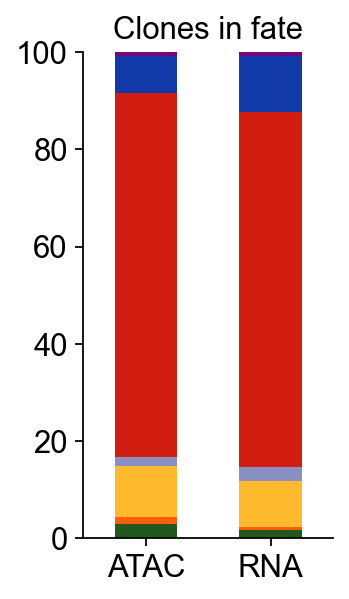

In [14]:
fig = plt.figure(figsize=(2,4))
ax=plt.axes()
sizes = clone_table.groupby(['fate','assay']).size()
props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index() 
props = props.pivot(columns='assay', index='fate').T
props.index = props.index.droplevel(0)
props.fillna(0, inplace=True)
props.plot(kind="bar", stacked=True, legend=False, ax=ax, color = colors)
plt.grid(False)
plt.xticks(rotation=0, ticks=[0,1],labels=['ATAC','RNA'])
plt.ylim(0,100)
plt.title('Clones in fate')
plt.xlabel('')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# plt.savefig("plots/clone_distr_fate.pdf")

# Plot clonal expansion for all clones on UMAP

In [16]:
adata_mult_coembed = sc.read_h5ad("../proc_files/lsk_full_coembed_whole_clones.h5ad")

In [17]:
umap_df = pd.DataFrame(np.hstack((adata_mult_coembed.obsm['X_draw_graph_fa'],(adata_mult_coembed.obs[['clone.size (RNA)','clone.size (ATAC)',
                                                                                                      'clone.size (RNA & ATAC)','fate_pct']].values))),
                       index=adata_mult_coembed.obs_names, columns=['x','y','size_rna','size_atac','size_net','fate_pct'])

In [18]:
umap_df = umap_df[(umap_df.size_net > 0)].copy()

In [19]:
leg = np.array([np.percentile(umap_df['size_net'].unique(), i) for i in [0,25,50,75,100]])
leg = np.round(leg)

In [20]:
size_vals = (umap_df.sort_values('size_net')['size_net'])

In [21]:
#mapper from scaled clone size to dot size
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(5,50))
scaler.fit(size_vals[~size_vals.isnull()].values.reshape(-1,1))

MinMaxScaler(feature_range=(5, 50))

In [22]:
#mapper from scaled clone size to viridis
pal = list(sns.color_palette('viridis', n_colors=len(size_vals[~size_vals.isnull()].sort_values().unique())).as_hex())
pal_mapper = {np.round(i,2):j for i,j in zip(size_vals[~size_vals.isnull()].sort_values().unique(), pal)}

In [23]:
np.round(leg)

array([ 2., 17., 32., 46., 87.])

In [24]:
# pal_mapper

No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


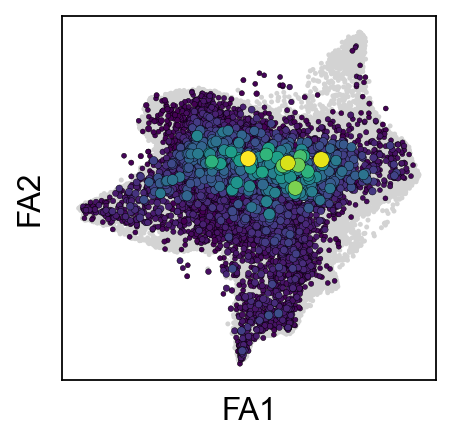

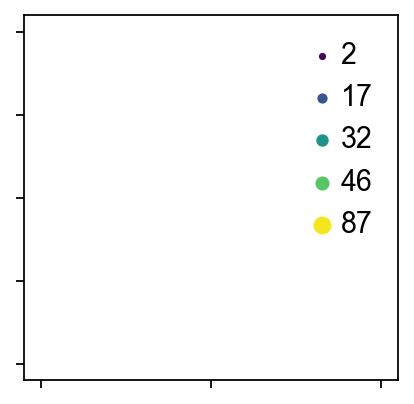

In [25]:
fig=plt.figure(figsize=(3,3))
ax=plt.axes()

sc.pl.draw_graph(adata_mult_coembed[adata_mult_coembed.obs.node_type=='cell'], s=20, ax=ax, show=False)
sns.scatterplot(x = 'x', y='y', data=umap_df.sort_values('size_net'),
               hue = 'size_rna', palette='viridis', edgecolor='black', linewidth=0.2,
                size=(umap_df.sort_values('size_net')['size_net']), sizes=(5,50), legend=False)

fig.savefig("../proc_files/plots/umap_coemb_clonal_expansion_net.pdf", dpi=300)

fig = plt.figure(figsize=(3,3))
ax=plt.axes()
for name, size in zip(leg,scaler.transform(leg.reshape(-1,1)).flatten()):
    plt.scatter([], [], s=size,c=pal_mapper[np.round(name)],
                label=str(int(name)))

ax.set_yticklabels([])
ax.set_xticklabels([])
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.5)
plt.yticks()
plt.grid(False)
# plt.savefig("plots/umap_coemb_clonal_expansion_net_legend.pdf")

# Plot deviation of clone-cell from cell-cell

In [26]:
adata_mult = sc.read_h5ad("../proc_files/lsk_mult_coemb.h5ad")

In [ ]:
sc.tl.draw_graph(adata_mult)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
umap_cells = adata_mult.obsm['X_draw_graph_fa']
umap_cells = pd.DataFrame(MinMaxScaler(feature_range=[-1,1]).fit_transform(umap_cells), columns=['cell1','cell2'], index = adata_mult.obs_names)

umap_clonecells = adata_mult_coembed.obsm['X_draw_graph_fa']
umap_clonecells = pd.DataFrame(MinMaxScaler(feature_range=[-1,1]).fit_transform(umap_clonecells), columns=['clone1','clone2'], index = adata_mult_coembed.obs_names)
umap_clonecells = umap_clonecells.loc[umap_cells.index].copy()

In [ ]:
umap_clonecells['dev'] = np.sqrt(((umap_cells.values - umap_clonecells.values)**2).sum(axis=1))

In [ ]:
adata_mult_coembed.obs = adata_mult_coembed.obs.merge(umap_clonecells[['dev']], right_index=True, left_index=True, how='left')

In [ ]:
fig = plt.figure(figsize=(9,3))
gs = GridSpec(1,3)

ax = plt.subplot(gs[0])
sc.pl.draw_graph(adata_mult, s=20, ax=ax, show=False)
plt.title('Embedding based on cells')

ax = plt.subplot(gs[1])
sc.pl.draw_graph(adata_mult_coembed, s=20, ax=ax, show=False)
plt.title('Clone cell embedding')

ax = plt.subplot(gs[2])
sc.pl.draw_graph(adata_mult_coembed, color='dev',s=20, ax=ax, show=False, colorbar_loc=None, cmap='Reds')
plt.title('Deviations')
# plt.savefig("plots/cce_deviations.pdf")

In [652]:
adata_mult_coembed.obs['final_celltype_simplified_2'] = adata_mult_coembed.obs.final_celltype_simplified

/Users/jindalk/opt/anaconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


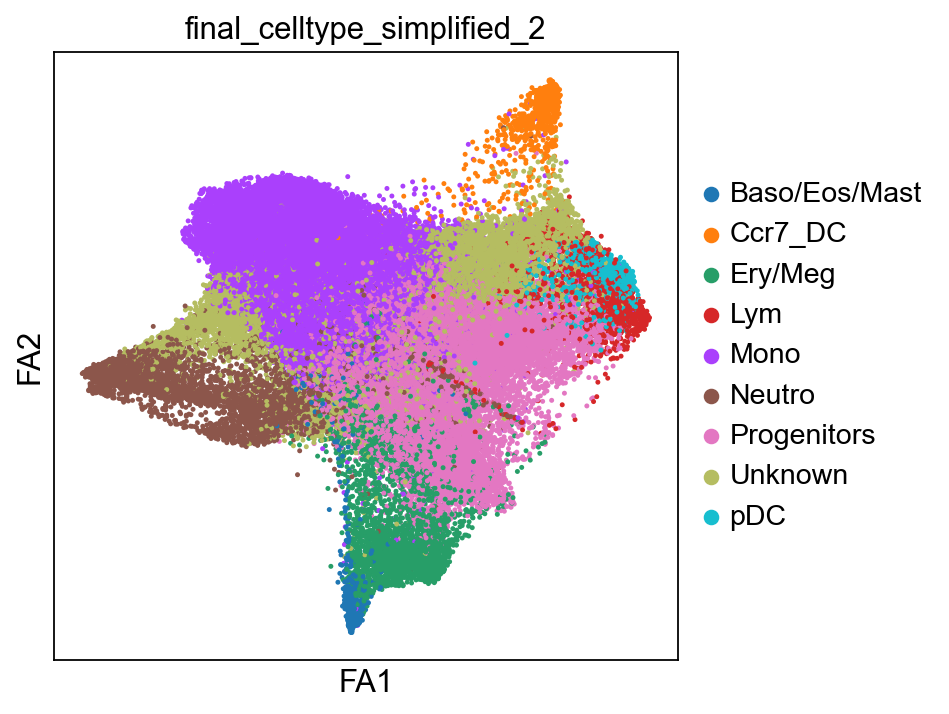

In [656]:
fig =sc.pl.draw_graph(adata_mult_coembed[adata_mult_coembed.obs.node_type=='cell'], color='final_celltype_simplified_2', s=20,
                      return_fig=True, show=False)
fig.savefig("plots/cc_emb_all_cellannots.pdf")